In [99]:
import torch
import torch.nn as nn
from torch.nn.functional import one_hot
from torch.distributions import Categorical, OneHotCategorical
from matplotlib import pyplot as plt
from unet import UNet
from tqdm import tqdm
import numpy as np
from difflib import SequenceMatcher

from unet import UNet
import glob
import os

from torch.utils.data import TensorDataset, DataLoader, Dataset
from PIL import Image

device='cuda' if torch.cuda.is_available() else 'cpu'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
ref_dataset = None

In [26]:
len(os.listdir('data/TinyCelebA'))

115329

In [43]:
K_colors = 16

In [44]:
#dataset = TensorDataset(torch.rand((3000, 30, 36, 256))) 
#dataloader = DataLoader(dataset, batch_size=500, shuffle=True) # create your dataloader#

In [45]:
def one_hotize(im, k=K_colors):
    ''' input: [0,1] HxW image
        output: {0,1} HxWxK image'''
    im = torch.floor(im/256.0*k).long()
    return torch.nn.functional.one_hot(im, k).permute((2,0,1))

def de_one_hotize(oh, dim=1):
    ''' input: {0,1} HxWxK image
        output: [0,1] HxW image'''
    return oh.argmax(dim)/oh.shape[dim]

In [69]:
class ImageDataset(Dataset):
    def __init__(self, root, k=None):
        end = "/*.jpg"
        self.files = sorted(glob.glob(root + end))
        if not k is None:
            self.files = self.files[:k]

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)]).convert('L')
        img = torch.tensor(np.array(img))
        return one_hotize(img)

    def __len__(self):
        return len(self.files)
dataset = ImageDataset('data/TinyCelebA',10000)
dataset[1].shape

torch.Size([16, 36, 30])

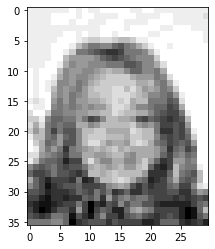

In [47]:
plt.imshow(de_one_hotize(dataset[2],0), cmap='gray')

In [48]:
dataloader = DataLoader(dataset, batch_size=500, shuffle=True) 

In [49]:


def cust_show(out,**kwargs):
    plt.imshow(out.cpu().detach().numpy(), **kwargs)
    plt.show()



In [50]:
class AODM(nn.Module):
    def __init__(self, h=36, w=30, k=K_colors, lr=1e-4):
        super().__init__()
        self.h, self.w, self.k = h, w, k
        self.d = self.h * self.w
        self.unet = UNet(self.k, self.k)
        self.lr = lr

    def forward(self, x):
        x_ = self.unet(x)
        return torch.log_softmax(x_, dim=1)

    def sample_t(self, N):
        return torch.randint(1, self.d + 1, (N, 1, 1), device=device)

    def sample_sigma(self, N):
        return torch.stack([torch.randperm(self.d, device=device).reshape(self.h, self.w) + 1 for _ in range(N)])

    def sigma_with_mask(self, mask):
        # sigma = [1.. mask_pixels || randperm (remaining pixels) ]
        sigma = torch.zeros((1, self.h, self.w), dtype=torch.long, device=device)
        sigma[mask] = torch.arange(mask.sum()) + 1
        sigma[~mask] = torch.randperm(self.d - mask.sum(), device=device) + mask.sum()
        return sigma

    def training_step(self, x):
        N, K, H, W = x.shape
        t = self.sample_t(N)
        sigma = self.sample_sigma(N)
        mask = sigma < t
        mask = mask.unsqueeze(1).float()
        x_ = self(x * mask)
        C = Categorical(logits=x_.permute(0, 2, 3, 1))
        l = (1. - mask) * C.log_prob(torch.argmax(x, dim=1)).unsqueeze(1)
        n = 1. / (self.d - t + 1.)
        l = n * l.sum(dim=(1, 2, 3))
        return {'loss': -l.mean(), 'input': x.detach(), 'generated': x_.detach()}

    def training_step_end(self, o):
        self.log('loss', o['loss'])

    def validation_step(self, *args, **kwargs):
        sample = self.sample_one()
        self.sample_quality(sample)
        return {'sample': sample.cpu()}

    def validation_epoch_end(self, outputs):
        self.log('sample_quality', self.sample_quality.compute())

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        return [opt]

    def sample_one(self):
        x = torch.zeros(1, self.k, self.h, self.w, device=device)
        sigma = self.sample_sigma(1)
        for t in range(1, self.d + 1):
            x = self.sample_step(x, t, sigma)
        return x

    def sample_one_seeded(self, x_seed, mask):

        # add masked pixels to seed
        x = torch.zeros(1, self.k, self.h, self.w, device=device)
        x[mask] = x_seed[mask]
        sigma = self.sigma_with_mask(mask)

        for t in range(mask.sum(), self.d + 1):
            x = self.sample_step(x, t, sigma)
        return x

    def sample_step(self, x, t, sigma):
        """
        Performs one step of the noise reversal transition function in order sigma at time t
        x: the current state
        t: the current timestep
        sigma: the order
        """
        past, current = sigma < t, sigma == t
        past, current = past.unsqueeze(1).float(), current.unsqueeze(1).float()
        logprobs = self((x * past))
        x_ = OneHotCategorical(logits=logprobs.permute(0, 2, 3, 1)).sample().permute(0, 3, 1, 2)
        x = x * (1 - current) + x_ * current
        return x

In [91]:
model = AODM().to(device)
#model.eval()
model = torch.load('face.pt')
L=[]

In [126]:
model.eval()
out = model.sample_one()

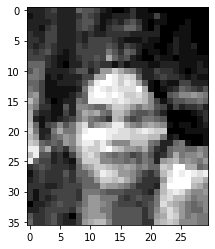

In [127]:
plt.imshow(de_one_hotize(out)[0].cpu().detach(), cmap='gray')

In [113]:
#model.lr = 1e-5
opt = model.configure_optimizers()[0]

In [122]:
for i in tqdm(range(100)):
   # model.eval()
    #out = model.sample_one()
    #plt.imsave('figs/epoch_{}.png'.format(i), out[0,1].cpu().detach().numpy())


    model.train()
    l=0
    torch.save(model, 'face2.pt')
    for idx, batch in enumerate(dataloader):
        x = batch.to(device)
        opt.zero_grad()
        out = model.training_step(x)
        loss = out['loss']
        l+=loss.item()
        loss.backward()
        opt.step()
    L.append(l)
   

  0%|                                                   | 0/100 [00:03<?, ?it/s]


KeyboardInterrupt: 

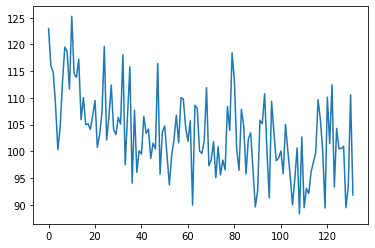

In [121]:
plt.plot(L)

# Find Closest


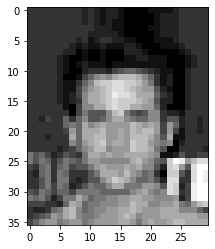

In [128]:
targ = de_one_hotize(out)[0].cpu().detach()
if ref_dataset is None:
    ref_dataset = torch.cat([de_one_hotize(dataset[i][None,...]) for i in range(len(dataset))])
def closest(out, dataset):
    return dataset[(((dataset-out.to('cpu'))**2).sum((1,2))).argmin()]

plt.imshow(closest(targ,ref_dataset), cmap='gray')

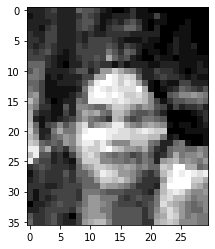

In [129]:
plt.imshow(targ, cmap='gray')